In [1]:
import MalekFinance as mf
import pandas as pd
import numpy as np
import datetime as dt
from pandas.tseries.offsets import MonthEnd
from matplotlib import pyplot as plt
from itertools import chain

In [2]:
prices_t_plus_1 = mf.read('LSEG Data','LSEG Futures Data Named Title',index_col=0,header=0,parse_dates=True)
returns = prices_t_plus_1.pct_change()
returns = returns.replace({0:np.nan})
returns.loc['2009-10-6','Heating Oil Futures'] = 0
returns.loc['2017-11-6','Japanese Yen'] = 0
returns.loc['2017-10-16','Japanese Yen'] = 0
prices_t_plus_1 = prices_t_plus_1.resample('M').last()
prices_t_plus_2 = mf.read('LSEG Data','LSEG Futures Data c2',index_col=0,header=1,parse_dates=True)
prices_t_plus_2.columns = prices_t_plus_2.columns.str.replace('c2', 'c1')
prices_t_plus_2.columns = prices_t_plus_2.columns.str.replace('^2', '')
prices_t_plus_2.columns = prices_t_plus_2.columns.str.replace('0', '')
prices_t_plus_2 = prices_t_plus_2.resample('M').last()
conversion = pd.read_excel('/Users/malek/Documents/LSEG Data/LSEG Futures RIC Codes.xlsx')
conversion.columns = ['1','2']
mydict = dict(zip(conversion['1'],conversion['2']))
prices_t_plus_2.rename(columns=mydict,inplace=True)

In [3]:
Equities = ['CAC 40 Future', 'DAX Future', 'DJ EURO STOXX 50', 
       'Dow Jones','FTSE 100 Future', 'Hang Seng Future',
       'Nikkei 225 Future', 'S&P 500', 'S&P 500 E-mini']
Bonds = ['Euro-Bobl Future','Euro-Bund Future', 'Euro-Schatz Future',
       'Long Gilt Future','U.S. Treasury 2-Year', 'U.S. Treasury 5-Year',
       'U.S. Treasury 10-Year', 'U.S. Treasury 30-Year']
STIRs = ['Euribor Future','Eurodollar','Euroswiss Future',
        'Interest Rate 30-Day','Short Sterling Future']
Metals = ['Copper Futures','Gold Futures','Silver Futures']
Agricultural = ['Corn Futures','Cotton Futures','Lumber Futures','Soybean Futures']
Energy = ['Brent Futures','Heating Oil Futures','Light Sweet Crude Futures','Natural Gas Futures','RBOB Gas']
GBP = ['British Pound']
CAD = ['Canadian Dollar']
EU = ['Euro']
CHF = ['Swiss Franc']
YEN = ['Japanese Yen']
Assets = [Equities,Bonds,STIRs,Metals,Agricultural,Energy,GBP,CAD,EU,CHF,YEN]
Universe = list(chain(*Assets))

In [4]:
returns = returns[Universe]
prices_t_plus_1 =prices_t_plus_1[Universe]
prices_t_plus_2 = prices_t_plus_2[Universe]
monthly_returns = returns.resample('M').agg(lambda x: (x+1).prod()-1)
monthly_returns.replace({0:np.nan},inplace=True)
formation_dates = pd.date_range('1981-12','2023-10-31',freq='M')
returns_dates = pd.date_range('1982-1','2023-11-30',freq='M')
formation_datesD = pd.date_range('1980-12','2023-10-31',freq='M')
filler = pd.DataFrame(index=formation_datesD)
returns = returns.combine_first(filler)
past_std = returns.ewm(span=252,min_periods=80).std()*(252**0.5) 
returns_datesD = returns['1981-01':].index
past_12 = (monthly_returns+1).rolling(12).apply(np.prod)-1
past_3 = (monthly_returns+1).rolling(3).apply(np.prod)-1
past_1 = (monthly_returns+1).rolling(1).apply(np.prod)-1
Dead = ['S&P 500','Eurodollar','Euroswiss Future','Lumber Futures','Short Sterling Future']
for col in Dead:
    returns[col].replace({0:np.nan},inplace=True)
def composite(past_x,formation):
    signal = past_x.loc[formation]
    for i in Assets:
        signal[signal.index.isin(i)] = signal[signal.index.isin(i)].mean()
    signal[signal > 0]=1
    signal[signal < 0]=-1
    return signal

# Integrated Carry + Trend

In [5]:
def Carry_Trend_FollowingD(formation):    
    Vol = pd.DataFrame(past_std.loc[formation]).dropna()
    Vol.replace({0:np.nan},inplace=True)
    Vol.dropna(inplace=True)
    Vol[Vol.iloc[:,0] < 0.01] = 0.01
    slow_lookback = composite(past_12,formation=formation)
    medium_lookback = composite(past_3,formation=formation)
    fast_lookback = composite(past_1,formation=formation)
    merged = pd.concat([slow_lookback,medium_lookback,fast_lookback],axis=1)
    merged['position'] = merged.sum(axis=1)
    merged['position'].replace({3:1},inplace=True)
    merged['position'].replace({-3:-1},inplace=True)

    t_plus_1 = pd.DataFrame(prices_t_plus_1.loc[formation])
    t_plus_2 = pd.DataFrame(prices_t_plus_2.loc[formation])
    Carry = (t_plus_2 - t_plus_1)/t_plus_1
    Carry.columns = ['Roll Yield']
    Carry.dropna(inplace=True)
    Long = pd.DataFrame(Carry['Roll Yield'][Carry['Roll Yield'] > 0])
    Short = pd.DataFrame(Carry['Roll Yield'][Carry['Roll Yield'] < 0])
    Long['Ranking'] = 1
    Short['Ranking'] = -1
    Signal = pd.concat([Long,Short],axis=0).sort_values(by='Ranking',ascending=False)

    Carry_Trend = pd.concat([Signal['Ranking'],merged['position']],axis=1).dropna()
    RET = monthly_returns.loc[formation + MonthEnd(1),monthly_returns.columns.isin(Carry_Trend.index)]
    wppp = pd.concat([RET,Carry_Trend,Vol],axis=1)
    wppp.columns = ['1 Month Forward Return','Carry Signal','Trend Signal','Ex Ante Vol']
    wppp.dropna(inplace=True)
    wppp['Portfolio Signal'] = wppp['Carry Signal'] + wppp['Trend Signal']
    wppp = wppp[['1 Month Forward Return','Carry Signal','Trend Signal','Portfolio Signal','Ex Ante Vol']]
    wppp['Natural Weighting'] = (1/wppp.iloc[:,4])/(sum(1/wppp.iloc[:,4])) * wppp.iloc[:,3]
    wppp.dropna(inplace=True)
    p = formation + MonthEnd(1)
    l = f'{p.year}-{p.month}'
    lenl = len(returns.loc[l].index)
    s = [[returns.loc[l].iloc[i]] for i in range(0,lenl)]
    wppp.drop([wppp.columns[0]],axis=1,inplace=True)
    def daily(i,wppp):
        wppp = wppp[wppp.index.isin(s[i][0].index)]
        s[i][0][s[i][0].index.isin(wppp.index)]
        wppp['1-Day Ret'] = s[i][0]
        wppp.dropna(inplace=True)
        momentum_profit = sum(wppp['Natural Weighting'] * wppp.iloc[:,5])
        return momentum_profit
    prof = [daily(i,wppp) for i in range(0,lenl)]
    return prof

collect = [Carry_Trend_FollowingD(i) for i in formation_datesD]
Daily_RET = list(chain(*collect))
Combined_ReturnsD = pd.DataFrame(Daily_RET,index=returns_datesD)

In [6]:
mf.summary_daily(Combined_ReturnsD)

Annual Return: 4.04%
Annual Volity: 3.99%
Sharpe Ratio: 1.01
Max Drawdown: -11.9%


# Vol Targetted Integrated Carry + Trend

In [7]:
def Carry_Trend_Following(formation):    
    Vol = pd.DataFrame(past_std.loc[formation]).dropna()
    Vol.replace({0:np.nan},inplace=True)
    Vol.dropna(inplace=True)
    Vol[Vol.iloc[:,0] < 0.01] = 0.01
    slow_lookback = composite(past_12,formation=formation)
    medium_lookback = composite(past_3,formation=formation)
    fast_lookback = composite(past_1,formation=formation)
    merged = pd.concat([slow_lookback,medium_lookback,fast_lookback],axis=1)
    merged['position'] = merged.sum(axis=1)
    merged['position'].replace({3:1},inplace=True)
    merged['position'].replace({-3:-1},inplace=True)

    t_plus_1 = pd.DataFrame(prices_t_plus_1.loc[formation])
    t_plus_2 = pd.DataFrame(prices_t_plus_2.loc[formation])
    Carry = (t_plus_2 - t_plus_1)/t_plus_1
    Carry.columns = ['Roll Yield']
    Carry.dropna(inplace=True)
    Long = pd.DataFrame(Carry['Roll Yield'][Carry['Roll Yield'] > 0])
    Short = pd.DataFrame(Carry['Roll Yield'][Carry['Roll Yield'] < 0])
    Long['Ranking'] = 1
    Short['Ranking'] = -1
    Signal = pd.concat([Long,Short],axis=0).sort_values(by='Ranking',ascending=False)

    Carry_Trend = pd.concat([Signal['Ranking'],merged['position']],axis=1).dropna()
    RET = monthly_returns.loc[formation + MonthEnd(1),monthly_returns.columns.isin(Carry_Trend.index)]
    wppp = pd.concat([RET,Carry_Trend,Vol],axis=1)
    wppp.columns = ['1 Month Forward Return','Carry Signal','Trend Signal','Ex Ante Vol']
    wppp.dropna(inplace=True)
    wppp['Portfolio Signal'] = wppp['Carry Signal'] + wppp['Trend Signal']
    wppp = wppp[['1 Month Forward Return','Carry Signal','Trend Signal','Portfolio Signal','Ex Ante Vol']]
    wppp['Natural Weighting'] = (1/wppp.iloc[:,4])/(sum(1/wppp.iloc[:,4])) * wppp.iloc[:,3]
    wppp.dropna(inplace=True)
    TT = len(Combined_ReturnsD[:formation])
    wppp['Vol Targetted Weight'] = wppp['Natural Weighting'] * (0.10/((Combined_ReturnsD[TT-252:TT].ewm(span=252).std()*(252**0.5)).iloc[-1,0]))
    Futures_Return = sum(wppp.iloc[:,0] * wppp['Vol Targetted Weight'])
    return [Futures_Return , wppp]
    

Combined_Returns = pd.DataFrame(data={'Carry_Plus_Trend':[Carry_Trend_Following(i)[0] for i in formation_dates]},index=returns_dates)

In [8]:
mf.summary(Combined_Returns)

Annual Return: 13.73%
Annual Volity: 12.58%
Sharpe Ratio: 1.09
Max Drawdown: -20.0%


Sharpe Ratio: 1.09


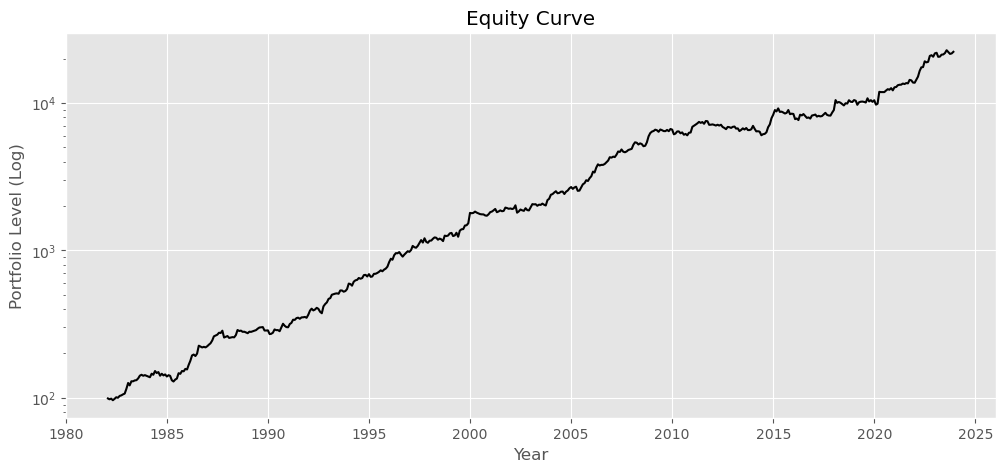

In [9]:
mf.plotequitycurve(Combined_Returns)

Annual Return: 13.73%


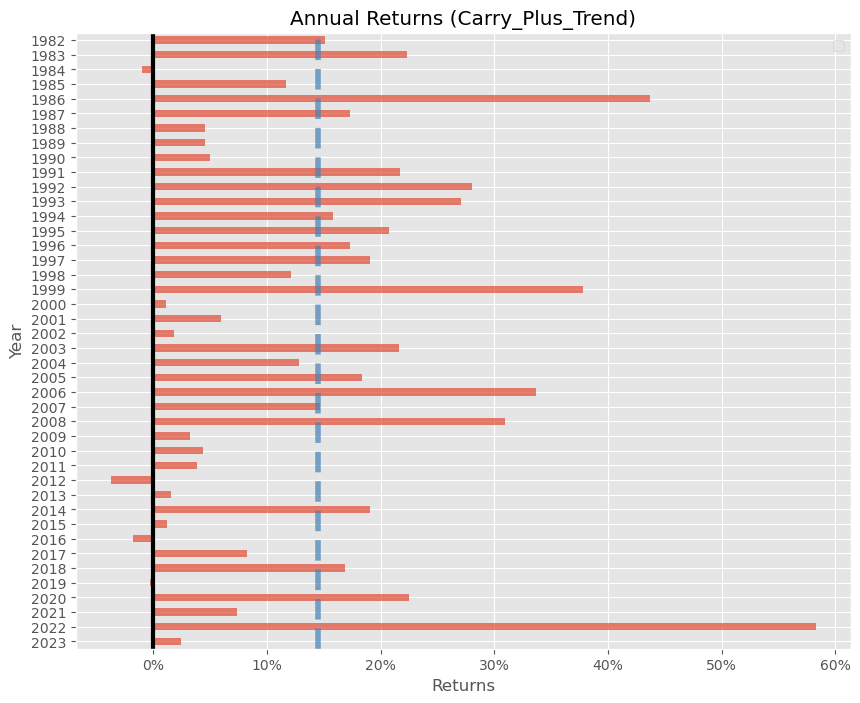

In [10]:
mf.plotyearly(Combined_Returns)

Max Drawdown: -20.0%


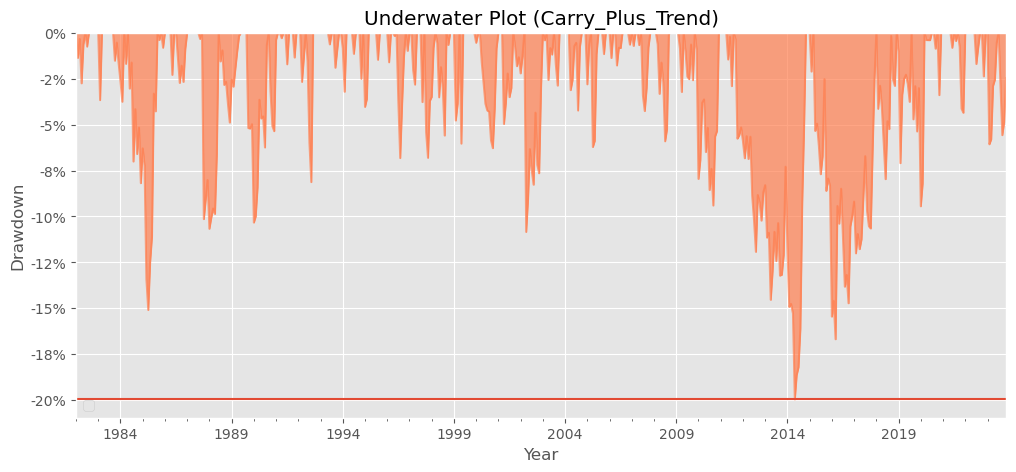

In [11]:
mf.plotdrawdown(Combined_Returns)

# Insight

In [12]:
Carry_Trend_Following(dt.datetime(2001,12,31))[1]

,1 Month Forward Return,Carry Signal,Trend Signal,Portfolio Signal,Ex Ante Vol,Natural Weighting,Vol Targetted Weight
CAC 40 Future,-0.032868,1.0,1.0,2.0,0.279251,0.014333,0.082534
DAX Future,-0.010408,1.0,1.0,2.0,0.332606,0.012033,0.069295
DJ EURO STOXX 50,-0.039927,-1.0,1.0,0.0,0.329451,0.000000,0.000000
FTSE 100 Future,-0.015736,1.0,1.0,2.0,0.226563,0.017666,0.101728
Hang Seng Future,-0.055907,1.0,1.0,2.0,0.308923,0.012956,0.074607
Nikkei 225 Future,-0.050669,1.0,1.0,2.0,0.306671,0.013051,0.075155
S&P 500,-0.016359,1.0,1.0,2.0,0.208058,0.019237,0.110776
S&P 500 E-mini,-0.016359,1.0,1.0,2.0,0.228730,0.017498,0.100764
Euro-Bobl Future,-0.001881,-1.0,-1.0,-2.0,0.043467,-0.092079,-0.530237
Euro-Bund Future,0.010301,-1.0,-1.0,-2.0,0.056609,-0.070702,-0.407138
